### purpose

see how marker choice affects performance

In [1]:
from pythonimports import *
from myfigs import slope_graph, adjust_box_widths, save_pdf

import MVP_summary_functions as mvp

import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import levene  # brown-forsythe test of equal variance

summarydir = '/work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/02_Q2'
figdir = makedir(op.join(summarydir, 'figs'))
pkldir = '/work/lotterhos/MVP-Offsets/run_20220919/summaries/all_performance_dicts'

mvp.latest_commit()
session_info.show()

#########################################################
Today:	February 09, 2023 - 11:01:37
python version: 3.8.5

Current commit of pythonimports:
commit b5f64910f19a2f05c80319052d8d8ce5edc6765a  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Mon Jan 30 10:30:11 2023 -0500

Current commit of MVP_offsets:
commit caa0fefccc33fb9bba80c1589c9992c24b1ca836  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Thu Feb 9 10:32:41 2023 -0500
#########################################################



<a id='data'></a>
# 1. load data

[top](#home)

In [2]:
# get all_scores data
all_scores = mvp.combine_level_dicts(use_bcs_data=False)

programs = keys(all_scores)
print(f'{programs = }')

# how many validation scores per seed (= num gardens)
for program, df in all_scores.items():
    print(program, df.index.value_counts().unique())
    
# show preview of last dataframe
df.head()

reading reps (use_bcs_data = False): 100%|███████████████| 5/5 [00:06<00:00,  1.32s/it]


0-225
	 RONA num seeds =  224
	 lfmm2 num seeds =  224
	 GF num seeds =  224
	 rda num seeds =  224


225-450
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


450-675
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


675-900
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225


900-1125
	 RONA num seeds =  225
	 lfmm2 num seeds =  225
	 GF num seeds =  225
	 rda num seeds =  225



 RONA df.shape = (674400, 15) num_seeds = 1124 num_reps = 5

 lfmm2 df.shape = (404400, 16) num_seeds = 1124 num_reps = 5

 GF df.shape = (337200, 15) num_seeds = 1124 num_reps = 5

 rda df.shape = (1078400, 17) num_seeds = 1124 num_reps = 5
programs = ['RONA', 'lfmm2', 'GF', 'rda']
RONA [600]
lfmm2 [600 300]
GF [300]
rda [1600  800]


,garden,score,glevel,plevel,pleio,slevel,landscape,popsize,migration,marker_set,seed,simulation_level,ntraits,structcrxn,noncausal_env,offset_level,rep,simulation_garden,final_LA,cor_TPR_temp,cor_TPR_sal
1231095,1,-0.953463,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,adaptive,1231095,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,ntraits-1,nocorr,no noncausal,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.505075,0.531414,NaN
1231095,2,-0.953463,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,adaptive,1231095,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,ntraits-1,nocorr,no noncausal,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.505075,0.531414,NaN
1231095,3,-0.953463,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,adaptive,1231095,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,ntraits-1,nocorr,no noncausal,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.505075,0.531414,NaN
1231095,4,-0.953463,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,adaptive,1231095,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,ntraits-1,nocorr,no noncausal,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.505075,0.531414,NaN
1231095,5,-0.953463,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,adaptive,1231095,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,ntraits-1,nocorr,no noncausal,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.505075,0.531414,NaN


In [47]:
# combine program dataframes into one df
dfs = []
for program, df in all_scores.items():
    df = df.copy()
    
    if 'structcrxn' in df.columns.tolist():
        df = df[df['structcrxn']=='nocorr']
    
    if program == 'RONA':
        df['program'] = 'RONA' + '-' + df['env']
        
    else:
        df['program'] = program
    
    dfs.append(df)

all_program_data = pd.concat(dfs)

all_program_data.head()

,garden,score,glevel,plevel,pleio,slevel,landscape,popsize,migration,marker_set,seed,simulation_level,env,offset_level,rep,simulation_garden,final_LA,cor_TPR_temp,cor_TPR_sal,program,ntraits,noncausal_env,structcrxn
1231095,1,0.333737,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,all,1231095,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,sal_opt,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.505075,0.531414,NaN,RONA-sal_opt,NaN,NaN,NaN
1231095,2,0.355556,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,all,1231095,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,sal_opt,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.505075,0.531414,NaN,RONA-sal_opt,NaN,NaN,NaN
1231095,3,0.374141,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,all,1231095,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,sal_opt,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.505075,0.531414,NaN,RONA-sal_opt,NaN,NaN,NaN
1231095,4,0.378586,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,all,1231095,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,sal_opt,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.505075,0.531414,NaN,RONA-sal_opt,NaN,NaN,NaN
1231095,5,0.357980,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,all,1231095,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,sal_opt,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.505075,0.531414,NaN,RONA-sal_opt,NaN,NaN,NaN


Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/02_Q2/figs/glevel_by_marker_set_performance_box.pdf


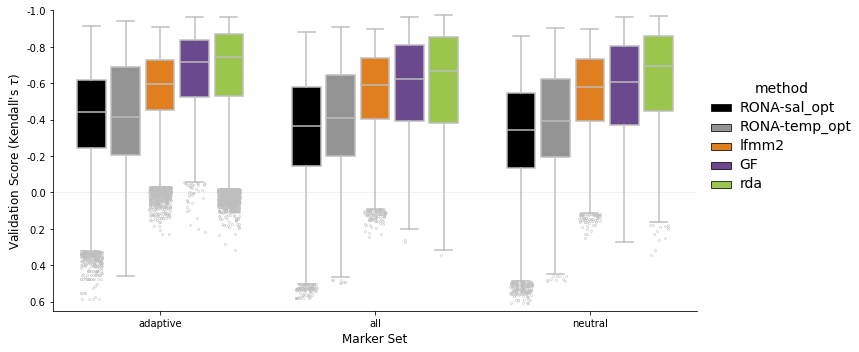

In [30]:
def cleanup_fig(g, xlabel="Landscape"):
    """Make the fig look rull pretty."""
    adjust_box_widths(list(g.axes[0]), 0.85)
    g.set(ylim=(0.65, -1),
          yticks=mvp.ytick_labels,
          yticklabels=mvp.ytick_labels)
    g.set_axis_labels(xlabel, "Validation Score (Kendall's $\\tau$)", fontsize=12)
    plt.setp(g.legend.get_texts(), fontsize='14') 
    plt.setp(g.legend.get_title(), fontsize='14')
    g.legend.set_bbox_to_anchor((1.03, 0.6))
    mvp.jitter_fliers(g)
    g.tight_layout()
    
    pass
    

g = sns.catplot(data=all_program_data,
                x='marker_set',
                y='score',
                hue='program',
                order=['adaptive', 'all', 'neutral'],
#                 hue_order=mvp.hue_order['program'],
                kind='box',
                height=5,
                aspect=2,
                **mvp.boxplot_kwargs
               )

cleanup_fig(g, xlabel='Marker Set')

g._legend.set_title('method')

# line at tau = 0
for ax in g.axes[0]:
    ax.axhline(0, linestyle='--', color='gainsboro', linewidth=0.5, zorder=0)
    
save_pdf(op.join(figdir, 'glevel_by_marker_set_performance_box.pdf'))

plt.show()

In [31]:
mvp.boxplot_kwargs['flierprops']

{'color': '#bebebe',
 'markeredgecolor': '#bebebe',
 'markerfacecolor': 'none',
 'markeredgewidth': 0.5,
 'markersize': 4,
 'marker': '.'}

In [35]:
boxen_kwargs = mvp.boxplot_kwargs.copy()

for key in ['whiskerprops', 'medianprops', 'flierprops', 'capprops']:
    boxen_kwargs.pop(key)


boxen_kwargs['line_kws'] = {'color' : 'white', 'zorder' : 2}

boxen_kwargs['box_kws'] = boxen_kwargs.pop('boxprops')
boxen_kwargs['box_kws'].update({'zorder' : 1, 'alpha' : 1.0})

boxen_kwargs['flier_kws'] = {'color': '#bebebe',
                             'edgecolor': '#bebebe',
                             'facecolor': 'none',
                             'linewidths': 0.5,
#                              's': 25,
#                              'marker': '.'
                            }

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/02_Q2/figs/glevel_by_marker_set_performance_boxen.pdf


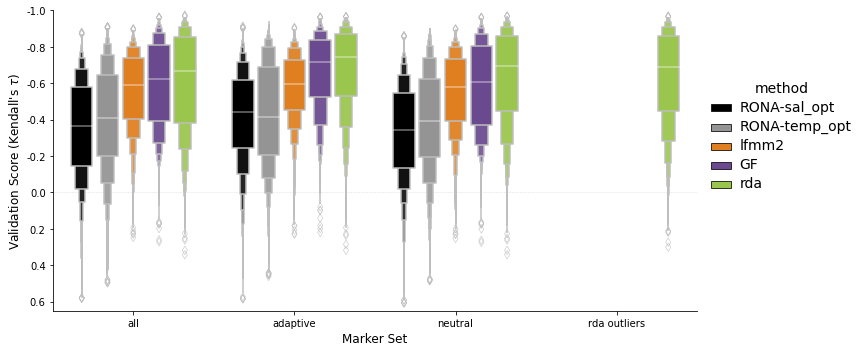

In [36]:
g = sns.catplot(data=all_program_data,
                x='marker_set',
                y='score',
                hue='program',
#                 hue_order=mvp.hue_order['program'],
                kind='boxen',
                height=5,
                aspect=2,
                **boxen_kwargs
               )

cleanup_fig(g, xlabel='Marker Set')

g._legend.set_title('method')

# line at tau = 0
for ax in g.axes[0]:
    ax.axhline(0, linestyle='--', color='gainsboro', linewidth=0.5, zorder=0)
    
save_pdf(op.join(figdir, 'glevel_by_marker_set_performance_boxen.pdf'))

plt.show()

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/02_Q2/figs/glevel_by_marker_set_performance_violin.pdf


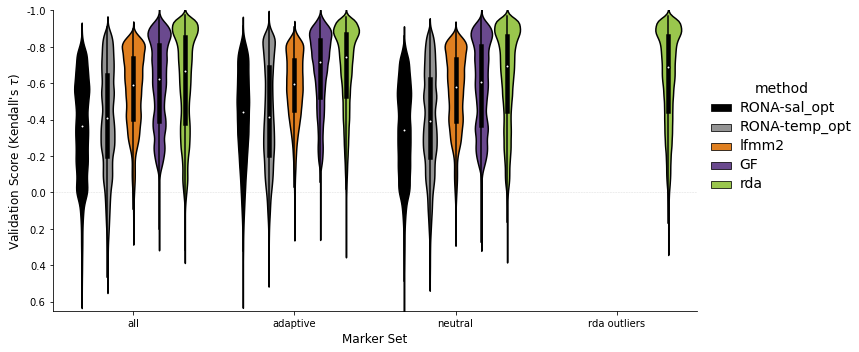

In [34]:
g = sns.catplot(data=all_program_data,
                x='marker_set',
                y='score',
                hue='program',
#                 hue_order=mvp.hue_order['program'],
                kind='violin',
                height=5,
                aspect=2,
                **boxen_kwargs
               )

cleanup_fig(g, xlabel='Marker Set')

g._legend.set_title('method')

# line at tau = 0
for ax in g.axes[0]:
    ax.axhline(0, linestyle='--', color='gainsboro', linewidth=0.5, zorder=0)
    
save_pdf(op.join(figdir, 'glevel_by_marker_set_performance_violin.pdf'))

plt.show()

# causal / non causal

In [40]:
all_program_data.head(2)

,garden,score,glevel,plevel,pleio,slevel,landscape,popsize,migration,marker_set,seed,simulation_level,env,offset_level,rep,simulation_garden,final_LA,cor_TPR_temp,cor_TPR_sal,program,ntraits,noncausal_env,structcrxn
1231095,1,0.333737,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,all,1231095,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,sal_opt,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.505075,0.531414,NaN,RONA-sal_opt,NaN,NaN,NaN
1231095,2,0.355556,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,all,1231095,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,sal_opt,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.505075,0.531414,NaN,RONA-sal_opt,NaN,NaN,NaN


In [49]:
all_cnc_df = all_program_data[all_program_data['noncausal_env'].notnull()].copy()

all_cnc_df.noncausal_env.value_counts()

all causal       900000
one noncausal    224000
no noncausal     156800
Name: noncausal_env, dtype: int64

In [43]:
all_cnc_df.head()

,garden,score,glevel,plevel,pleio,slevel,landscape,popsize,migration,marker_set,seed,simulation_level,env,offset_level,rep,simulation_garden,final_LA,cor_TPR_temp,cor_TPR_sal,program,ntraits,noncausal_env,structcrxn
1231095,1,-0.870707,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,all,1231095,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,NaN,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.505075,0.531414,NaN,lfmm2,ntraits-1,no noncausal,NaN
1231095,2,-0.870303,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,all,1231095,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,NaN,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.505075,0.531414,NaN,lfmm2,ntraits-1,no noncausal,NaN
1231095,3,-0.870707,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,all,1231095,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,NaN,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.505075,0.531414,NaN,lfmm2,ntraits-1,no noncausal,NaN
1231095,4,-0.870303,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,all,1231095,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,NaN,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.505075,0.531414,NaN,lfmm2,ntraits-1,no noncausal,NaN
1231095,5,-0.872727,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,all,1231095,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,NaN,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.505075,0.531414,NaN,lfmm2,ntraits-1,no noncausal,NaN


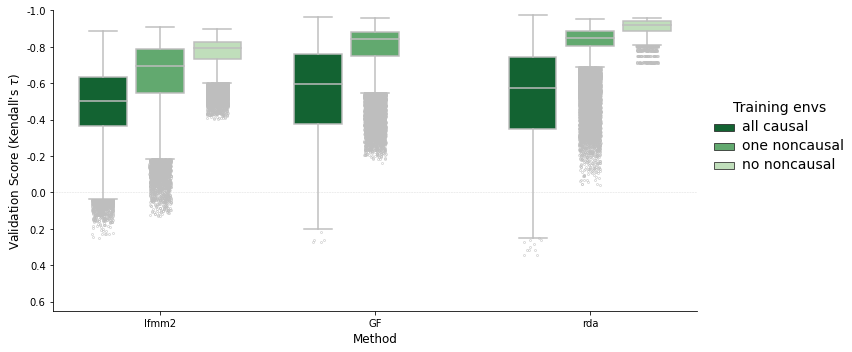

In [52]:
g = sns.catplot(data=all_cnc_df,
                x='program',
                y='score',
                hue='noncausal_env',
                hue_order=mvp.hue_order['noncausal_env'],
                kind='box',
                height=5,
                aspect=2,
                **mvp.boxplot_kwargs
               )

cleanup_fig(g, xlabel='Method')

g._legend.set_title('Training envs')

# line at tau = 0
for ax in g.axes[0]:
    ax.axhline(0, linestyle='--', color='gainsboro', linewidth=0.5, zorder=0)

In [53]:
all_cnc_df.head(2)

,garden,score,glevel,plevel,pleio,slevel,landscape,popsize,migration,marker_set,seed,simulation_level,env,offset_level,rep,simulation_garden,final_LA,cor_TPR_temp,cor_TPR_sal,program,ntraits,noncausal_env,structcrxn
1231095,1,-0.870707,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,all,1231095,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,NaN,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.505075,0.531414,NaN,lfmm2,ntraits-1,no noncausal,NaN
1231095,2,-0.870303,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,all,1231095,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,NaN,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0-225,highly-polygenic_1-trait_no-pleiotropy_nan_Est...,0.505075,0.531414,NaN,lfmm2,ntraits-1,no noncausal,NaN


In [54]:
all_cnc_df[all_cnc_df['program']=='GF']['noncausal_env'].value_counts()

all causal       270000
one noncausal     67200
Name: noncausal_env, dtype: int64

In [ ]:
formatclock(dt.now() - t1, exact=True)